Image dataset containing samples of meningioma(1), glioma(2), pituitary tumor(3) brain tumor types.

Cheng, Jun (2017): brain tumor dataset. figshare. Dataset. https://doi.org/10.6084/m9.figshare.1512427.v5

# Zaimportowanie potrzebnych bibliotek

In [2]:
import tensorflow as tf
from keras import Model
import matplotlib.pyplot as plt
import cv2
from keras.applications import DenseNet121
from keras.layers import *
from keras.callbacks import *
import numpy as np
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import seaborn as sns
from sklearn.utils import class_weight

# Sprawdzenie aktywności karty graficznej

In [3]:
!nvidia-smi

Mon Jun 19 11:49:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 527.41       Driver Version: 527.41       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:2B:00.0  On |                  N/A |
| 40%   51C    P0    41W / 175W |    333MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Utworzenie zmiennych zawierających często używane ścieżki i wyświetlenie liczby obrazów w zestawie danych

215 images in 'C:/Users/Jakub/PycharmProjects/BigDataProjekt/data_SL\test\Glioma'.
107 images in 'C:/Users/Jakub/PycharmProjects/BigDataProjekt/data_SL\test\Meningioma'.
140 images in 'C:/Users/Jakub/PycharmProjects/BigDataProjekt/data_SL\test\Pituitary'.
998 images in 'C:/Users/Jakub/PycharmProjects/BigDataProjekt/data_SL\train\Glioma'.
495 images in 'C:/Users/Jakub/PycharmProjects/BigDataProjekt/data_SL\train\Meningioma'.
651 images in 'C:/Users/Jakub/PycharmProjects/BigDataProjekt/data_SL\train\Pituitary'.
213 images in 'C:/Users/Jakub/PycharmProjects/BigDataProjekt/data_SL\val\Glioma'.
106 images in 'C:/Users/Jakub/PycharmProjects/BigDataProjekt/data_SL\val\Meningioma'.
139 images in 'C:/Users/Jakub/PycharmProjects/BigDataProjekt/data_SL\val\Pituitary'.
['Glioma', 'Meningioma', 'Pituitary']


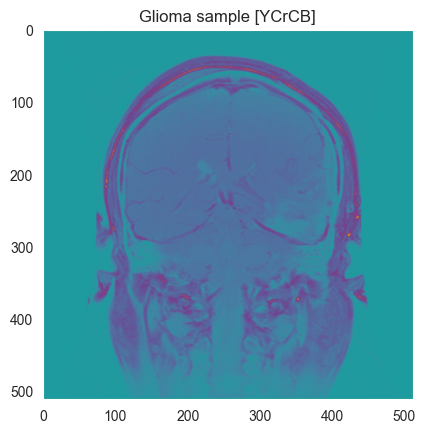

In [4]:
for dirpath, dirnames, filenames in os.walk("C:/Users/Jakub/PycharmProjects/BigDataProjekt/data_SL"):
    if len(filenames) != 0:
        print(f"{len(filenames)} images in '{dirpath}'.")

train_dir = "C:/Users/Jakub/PycharmProjects/BigDataProjekt/data_SL/train/"
test_dir = "C:/Users/Jakub/PycharmProjects/BigDataProjekt/data_SL/test/"
val_dir = "C:/Users/Jakub/PycharmProjects/BigDataProjekt/data_SL/val/"

classes = []
for name in os.listdir(train_dir):
    classes.append(name)

print(classes)

img_array = cv2.imread("C:/Users/Jakub/PycharmProjects/BigDataProjekt/data_SL/train/Glioma/0.png", -1)
img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2YCrCb)
plt.imshow(np.real(img_array))
plt.title("Glioma sample [YCrCB]")
plt.grid(False)
plt.show()
#

# Wczytywanie zdjęć

In [5]:
def myfunc(image):
    image = np.asarray(image).astype('float32')
    hsv_image = cv2.cvtColor(image,cv2.COLOR_RGB2YCrCb)
    return hsv_image

# powyższa funkcja ma za zadanie przekonwertować format zdjęcia z RGB na YCbCr po jego odczytaniu [preprocessing_function = myfunc]

In [6]:
# W tym miejscu deklarujemy generator danych ze zdjęć, wykonuje przeskalowanie wartości pikeli do zakresu 0-1 oraz wykonuje on augmentację zdjęć treningowych (losowa zmiana wysokości oraz szerokości zdjęcia plus jego losowa rotacja)

train_datagen = ImageDataGenerator(rescale = 1/255,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range=5,
                                  preprocessing_function = myfunc)

test_datagen = ImageDataGenerator(rescale = 1/255,
                                  preprocessing_function = myfunc)

In [7]:
IMAGE_SHAPE = (224, 224) # Zadeklarowanie rozmiaru zdjęć, 224 na 224 to podstawowy rozmiar zdjęcia dla sieci DenseNet121
BATCH_SIZE = 32 # Zadeklarowanie ilości zdjęć które będą w jednej paczce podczas uczenia modelu

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

val_data = test_datagen.flow_from_directory(val_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Found 2144 images belonging to 3 classes.
Found 462 images belonging to 3 classes.
Found 458 images belonging to 3 classes.


# Zaimportowanie potrzebnych bibliotek

In [8]:
base_model = DenseNet121(
    include_top=False,
    weights="imagenet",
    input_tensor=Input(shape=(IMAGE_SHAPE+(3,)))
)

# Powyżej deklarujemy model, nie chcemy oryginalnych warstw klasyfikacyjnych modelu DenseNet121, ponieważ chcemy dodać własne warstwy klasyfikacyjne do naszego modelu, a więc ustawiamy parametr include_top na False, parametr weights="imagenet" zapewnia nam wczytanie wag pretrenowanego modelu na zbiorze ImageNet, oraz na koniec podajemy rozmiar tensora podawanego do modelu (Rozmiar zdjęcia + 3 jego kanały)

In [9]:
# W naszym przypadku zbiór zdjęć jest mocno niezbilansowany (1 klasa - 1400 zdjęć, 2 - 900, 3 - 700), dlatego wykonuje się dodanie wag do poszczególnych klas, aby te które posiadają więcej zdjęć odpowiednio mniej wpływały na naukę modelu, a te których zdjęć mają więcej - bardziej. Pozwala to zdredukowanie preferowania jednej klasy podczas uczenia się, co mogłoby wpłynąć na dokładnośc modelu.

class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_data.classes),
                                                  y=train_data.classes)
class_weights = dict(enumerate(class_weights))

In [10]:
# W tym miejscu dodawana jest głowa modelu "ostatnie wartstwy", która odpowiadać będzie za klasyfikację

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(256, activation='relu')(x)
x=Dropout(0.25)(x) # Usuwamy 25 % losowo wybranych neuronów, aby zmniejszyć prawdopodobieństwo przetrenowania sieci.
prediction=Dense(3, activation='softmax')(x) # Ostatnia warstwa posiada 3 wyjścia, ponieważ będziemy klasyfikować 3 klasy, a aktywacja softmax będzie generowała prawdopodobieństwo wystąpienia danej klasy na zdjęciu.

model = Model(inputs=base_model.input, outputs = prediction)

model.summary() # Tak prezentują się wszystkie warstwy modelu

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [11]:
# W tym miejscu wykonywana jest kompilacja modelu.

model.compile(optimizer=tf.keras.optimizers.Adam(.5e-5), # Prędkośc uczenia została zredukowana odpowiednio do naszego problemu (Większa prędkośc uczenia się prowadziła do omijania optimów przez optimizer co skutkowało w fluktuacji dokładności podczas walidacji.
    loss="BinaryCrossentropy",
    metrics=["accuracy"],
    )

In [12]:
# Klasa ModelCheckpoint umożliwia nam monitorowanie dokładności modelu podczas uczenia się, dzięki czemu możemy zapisywać model gdzie wagi wygenerowały najlepszą dokładność.

train_steps = train_data.samples // BATCH_SIZE
test_steps= test_data.samples // BATCH_SIZE
val_steps = val_data.samples // BATCH_SIZE

callback = ModelCheckpoint("saved_models/best_model[ycbcr,adam].hdf5",
                           monitor='val_loss',
                           verbose=1,
                           save_best_only=True,
                           mode='auto',
                           save_freq="epoch")

print(train_steps,  test_steps, val_steps)

67 14 14


In [13]:
# Dopasowanie naszego modelu do danych

history = model.fit(
    train_data,
    steps_per_epoch=train_steps,
    epochs = 50, # Ilość epok do nauki modelu
    validation_data=val_data,
    validation_steps=val_steps,
    callbacks=[callback],
    class_weight=class_weights # W tym miejscu dodajemy uprzednio wyliczone wagi klas
)

Epoch 1/50
67/67 [==============================] - ETA: 0s - loss: 0.7530 - accuracy: 0.3554
Epoch 1: val_loss improved from inf to 0.65738, saving model to saved_models\best_model[ycbcr,adam].hdf5
67/67 [==============================] - 55s 525ms/step - loss: 0.7530 - accuracy: 0.3554 - val_loss: 0.6574 - val_accuracy: 0.3013
Epoch 2/50
67/67 [==============================] - ETA: 0s - loss: 0.5333 - accuracy: 0.6152
Epoch 2: val_loss improved from 0.65738 to 0.61342, saving model to saved_models\best_model[ycbcr,adam].hdf5
67/67 [==============================] - 39s 579ms/step - loss: 0.5333 - accuracy: 0.6152 - val_loss: 0.6134 - val_accuracy: 0.4487
Epoch 3/50
67/67 [==============================] - ETA: 0s - loss: 0.4265 - accuracy: 0.7659
Epoch 3: val_loss improved from 0.61342 to 0.56544, saving model to saved_models\best_model[ycbcr,adam].hdf5
67/67 [==============================] - 36s 536ms/step - loss: 0.4265 - accuracy: 0.7659 - val_loss: 0.5654 - val_accuracy: 0.5960

# Ewaluacja modelu

In [14]:
model.load_weights("saved_models/best_model[ycbcr,adam].hdf5") # Załadowujemy z pliku model gdzie wystąpiła najniższa wartość funkcji straty dla danych walidacyjnych

print("Accuracy:", round(model.evaluate(test_data, steps=None, return_dict=True)["accuracy"], 4)*100, "%") # Wyświetlamy dokładność modelu testując go na danych testowych

15/15 [==============================] - 5s 365ms/step - loss: 0.0805 - accuracy: 0.9567
Accuracy: 95.67 %


# Wizualizacja procesu nauki modelu

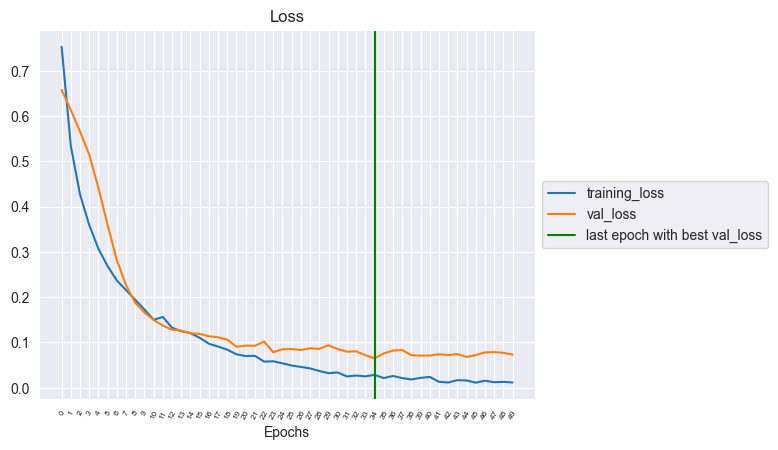

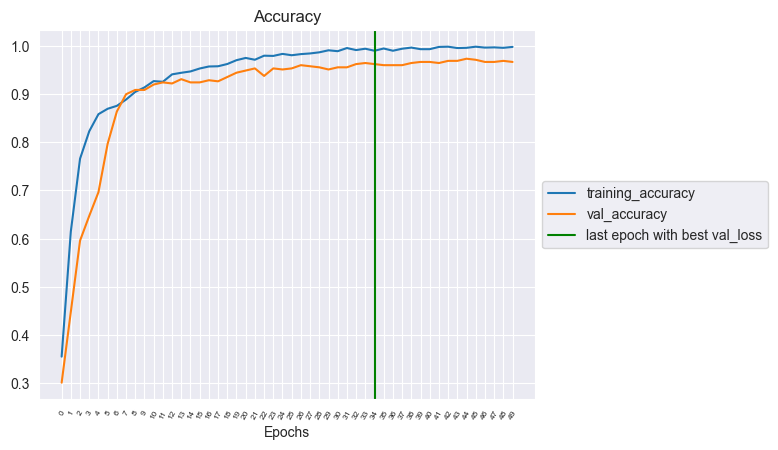

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(history.history['loss']))

plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.axvline(x=np.argmin(history.history["val_loss"]), color="green", label='last epoch with best val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.xticks(ticks=np.arange(0, len(history.history['loss'])), rotation = 60, fontsize=6)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.figure()
plt.plot(epochs, accuracy, label='training_accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.axvline(x=np.argmin(history.history["val_loss"]), color="green", label='last epoch with best val_loss')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.xticks(ticks=np.arange(0, len(history.history['loss'])), rotation = 60, fontsize=6)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Macierz pomyłek

In [16]:
model.load_weights("saved_models/best_model[ycbcr,adam].hdf5")

test_datagen = ImageDataGenerator()

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical",
                                              shuffle=False)

y_pred = model.predict(test_data, workers=0)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_data.classes[test_data.index_array]

Found 462 images belonging to 3 classes.
15/15 [==============================] - 10s 583ms/step


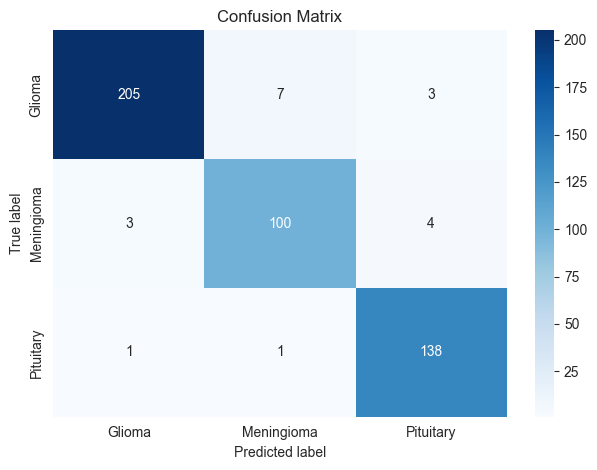

In [17]:
cm = confusion_matrix(y_true, y_pred_classes)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)

plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()

plt.show()